# Day 1 of AI Academy 2022 - NLP Track

Hi There! Welcome to day 1 lab in your AI Academy 2022 program, NLP track. In this lab, we'll go through the process of exploratory data analysis and building a baseline model. In the end of our lab, there will be some exercise that should help move towards your final project and will help you deepen your understanding of the material. Before we start hacking away, let's have a quick reminder of the business usecase we're trying to solve.

## Quick Recap of the Use Case
A compay called **Super Fast Telecom Solutions**, which operates mobile and internet networks, has approached us with a problem. Their problem is that a lot of theri customers are tweeting about their services and the issues they face with it and customer support representatives are not fast enough to go through the tweets, identify the ones reposrting an issue in order to communicate with the customers and solve their issues. To make things faster, they need a way to quickly flag tweets that contain a problem or a negative opinion about their services and priortrize them so that they can be addressed quickly. They want to build a **brand monitoring** application that would allow them to:
1. Identify tweets with negative sentiment and flag them for quick response from the custome service representative.
2. Review the overall sentiment about their services across time.

Before sharing the data they have with you, Super Fast Teelcom Solutions requested that we show them a PoC of a sentiment analysis model that would be the core AI feature in such a brand monitoring system. They however shared other tweets data, unrelated to their brand, that should be similar in distribution to their brabnd-related data.

The syetem they desire should be bi-lingual (supporting both English and Arabic), and they shared data in both languages and they are provide under the `data` directory in this repository. For each language, we're given three CSV files:
- `train.csv` for the training data
- `dev.csv` for data to be used in model development (e.g. hyper-parameters tuning)
- `test.csv` to test our models against.

## Step 1: Exploratory Data Analysis (EDA)
The very first step in our process would be to look into the data itself and explore its different aspects and charactristics in order to build a suitable model. In exploratory data analysis, or EDA for short, we try to probe into the data and answer some specific questions like:
- How much data do we have?
- What is the distribution of the classes? is the data blanced or skewed twoards a specific class?
- How long is the tweets? does that differ from one class to another?
- What are the most common words, and what are the least common words? What about per class?
- How much unique vocabulary is there? What is the most informative?

Answering these questions and more would guide us to towards building a more suitable model for the data we have; should we try to fix the imbalance in the data? what kind of preocessing do we need to do in order to make the problem more approachable? what is the best metric to track in our experiments? ... etc.

### Class Exploration
Our first exploration would be into the classess associated with the data we have: how many are they? and what's their distribution. Let's first take a look at the head of our data and understand how the CSV files are formatted.

In [2]:
import pandas as pd

english_training_data = pd.read_csv("data/english/train.csv")
english_training_data.head(3)

,tweet,label
0,This time tomorrow\u002c @quinnjessica and I w...,negative
1,@cassiehendrix are you in the land of my fathe...,neutral
2,False start penalty\u002c Garner moved early. ...,negative


We can see from the output above is that our data is formatted into two cloumns: one called `tweet` and contains the tweet text itself, and the other called `lable` and holds the designated sentiment of the tweet. We can see two distinct labels in the sample above: `neutral` and `negative`, but that doens't mean that the whole data set contains these two labels. To get all the distinct labels in the data, we utilize the `unique` method in `pandas` as follows.

In [3]:
english_training_data.loc[:, "label"].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

What we did above is that we selected all the rows in our dataframe, and only the column called `label`, then the unique method reported to us another label in addition to the two we observed above, the `positive` label. It's safe to assume now that our data come with three classes: `poitive` indicating tweets that hold a postive opinion or sentiment, `negative` for the negative ones, and `neutral` for the tweets that do not have any sentiment or opinionated views. The question now is how are these three classes distributed?

To answer this question, we'll utilize `seaborn` as a visualization package to give us a bar plot indicating the counts of the samples for each of the three classes, as well as the `groupby` feature from pandas to look at the prcises counts for each class. 

negative: 429 samples
neutral: 202 samples
positive: 613 samples


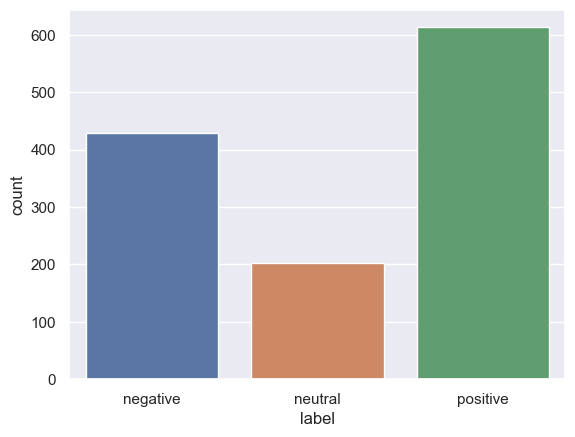

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.countplot(data=english_training_data, x="label")

classes_groups = english_training_data.groupby("label")
for group_key, group_df in classes_groups:
    print(f"{group_key}: {len(group_df)} samples")

As we can see from the samples count above and the count plot, our data is imabalnced, with the majority of data being on the positive side of sentiments. This observation should make us think about what is the metric that we should use to evaluate the models that we're going to build.

_**Discussion Question: refer back to the metrics we discussed in the morning (accuracy, f1-score and its variants), what is the best metric to use here, and why? (keep in mind the business requirement of the project while you think of an answer)**_

_..._

Another thing that we notice form that exercise, beside the class imbalance, is that we only have 1244 training samples, which is not much and this will require us to think about models that are sample effcient in order to learn something for such a relatively small data set.

---

### Length Exploration

The next thing we can look at is how long is our text. We can do so by applying a function along the tweets column that tockenizes the tweet by whitespaces and reports the length of the tokens list. We can run the `describe` method from `pandas` from the output of the applied function and get various descrtiptive statistics about the obverall lengths of the tweets. We choose to report the minimum length, maximum length, and the mean with standrad deviation. We also use the `histplot` from `seaborn` to render a histogram of the tweet lengthes that would give us more visibility into the distribution of the lengthes.

Overall Tweets Length
	Min = 5.0, Max = 35.0
Mean ± std: 20.9 ± 5.0


<AxesSubplot: xlabel='tweet_lengths', ylabel='Count'>

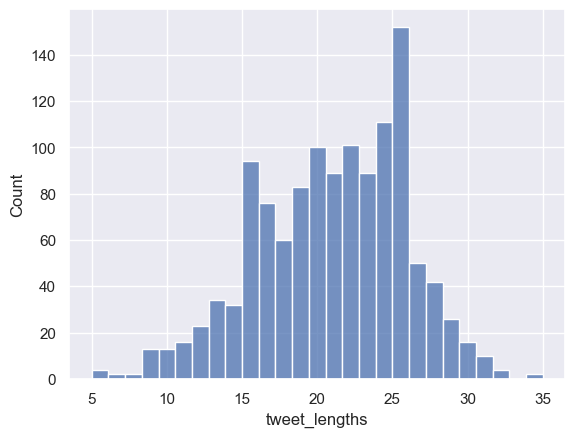

In [24]:
tweet_lengths = english_training_data.loc[:, "tweet"].apply(lambda tweet: len(tweet.split(" ")))
tweet_lengths.name = "tweet_lengths"

tweet_length_stats = tweet_lengths.describe()
print("Overall Tweets Length")
print(f"\tMin = {tweet_length_stats['min']}, Max = {tweet_length_stats['max']}")
print(f"Mean ± std: {tweet_length_stats['mean']:.1f} ± {tweet_length_stats['std']:.1f}")

sns.histplot(tweet_lengths)

_**Exercise: Run the same length exploration as above but on each individual class in the data.**_

In [33]:
# Write your solution here

As we can see from the results above, the length of the tweets (in terms of words) is around 20 words per sampple, which is good news for the sequence based models we can use (like recurrent neural network and transfromers) because it means that we can process these tweets with a samll computational footprint.

---

### Vocabulary analysis

The last kind of exploratory analysis we'll do here is the vocabulary analysis. With this analysis, we shed some light on the necessary preprocessing we need to carry out on the data before we can train any model. We do our vocabulary analysis by looping through the tweets we have and tokenize them and count the occurance of each word in a dictionary. We then use this dictionary to get the 100 most common and the least common words in the dataset and plot in a bar plot fashion.

Number of Unique Tokens: 8537


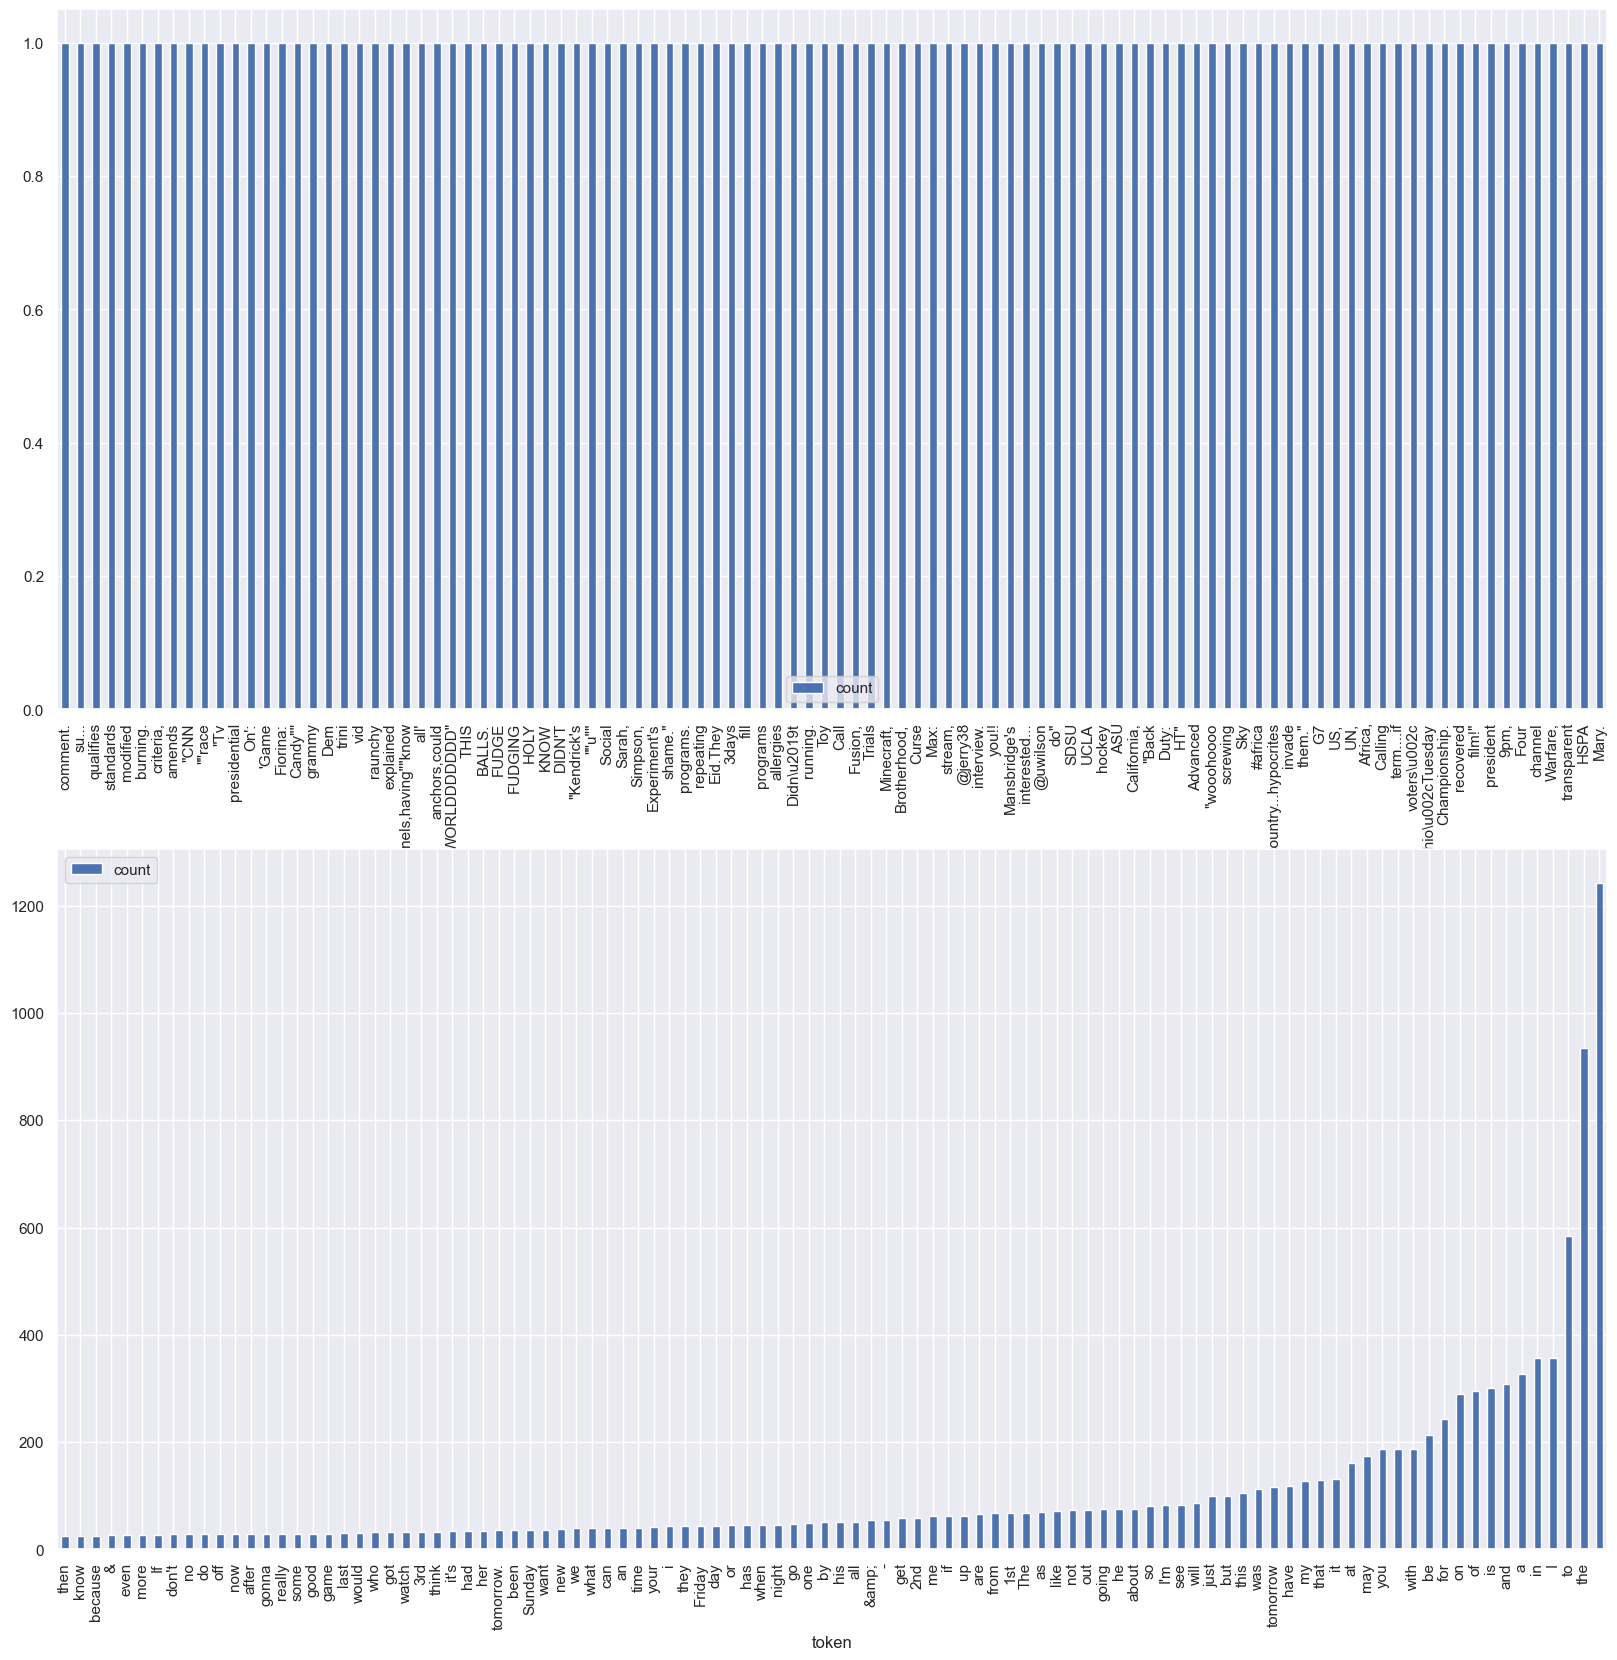

In [53]:
from collections import defaultdict
import numpy as np

word_count = defaultdict(int)
_, axes = plt.subplots(2, 1, figsize=(20, 20))

for i, row in english_training_data.iterrows():
    tweet = row["tweet"]
    tokens = tweet.split(" ")
    for token in tokens:
        word_count[token] += 1

unique_tokens = list(word_count.keys())
unique_tokens_count = list(word_count.values())

sorted_token_indecies = np.argsort(unique_tokens_count)
least_100_frequent_tokens_indecies = sorted_token_indecies[:100]
most_100_frequent_tokens_indecies = sorted_token_indecies[-100:]

least_100_frequent_tokens = [unique_tokens[i] for i in least_100_frequent_tokens_indecies]
least_100_frequent_tokens_counts = [unique_tokens_count[i] for i in least_100_frequent_tokens_indecies]
most_100_frequent_tokens = [unique_tokens[i] for i in most_100_frequent_tokens_indecies]
most_100_frequent_tokens_counts = [unique_tokens_count[i] for i in most_100_frequent_tokens_indecies]

pd.DataFrame({"token": least_100_frequent_tokens, "count": least_100_frequent_tokens_counts}).plot.bar(x="token", y="count", ax=axes[0])
pd.DataFrame({"token": most_100_frequent_tokens, "count": most_100_frequent_tokens_counts}).plot.bar(x="token", y="count", ax=axes[1])

print(f"Number of Unique Tokens: {len(unique_tokens)}")

As we can see from the analysis above, we have around 9k unique words in the data, this number could be challangeing for vocabulary-based modeling approaches (like Bag of words and TFIDF) especially withe the low number of samples we have in the dataset. However, if we looked at the plots above, we can see lots of capitalized words and words precedded with quotes and double qoutes, we can aslo see user mentions (makes sense given that we're daeling with tweets). All these observations suggest that some cleaning approaches and preprocessing on the data would take down the number of unique vocabulary considerably and make the problem more tractable.


## Step 2: Data Cleaning and Preprocessing